## Introduction to Data Challenge

For the data challenge, my goal was to do as much work as possible using SQL rather than python pandas for practice. I imported the csv files for the challenged into postgres (the hard way, not using python). I did some additional data cleaning, such as removing the times from the time_stamp (postgres was giving me issues with time stamp conversions).

Most of the heavy preprocessing was done in SQL before I tried to do anything in python / pandas etc. I wanted to accomplish the following:

1) Can I come up with answers using data manipulations mostly in SQL? 

2) Do actionable insights really necessitate the use of ML, depending on the question? For example, if we want to know whether or not to raise prices, will a simple figure suffice for decision making, or do we actually need to implement an actual model?

In [1]:
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
import statsmodels.api as sm
import psycopg2
import pandas as pd
import sqlalchemy
import numpy as np
import matplotlib.pyplot as plt

**For the data challenge, I decided to try to do all of the data clean up and calculations in SQL.**

In [2]:
con = psycopg2.connect(database = 'data_challenge', user = 'michelle', password = 'gundam91', host = '/var/run/postgresql')

In [3]:
sql_query = """
SELECT *
FROM test_results
WHERE false;
"""
pd.read_sql_query(sql_query, con)

,id,time_stamp,source,device,os,test,price,converted


**Let just peek at how many rows of data there are in the dataset.** Note that the proportions for the control and test data match the description, which is a good sanity check.

In [4]:
sql_query = """
SELECT count(test) as Total_Num_Samples, round((count(test) * 100 /(SELECT COUNT(*) from test_results)),3) AS total
FROM test_results
GROUP BY test;
"""
pd.read_sql_query(sql_query, con)

,total_num_samples,total
0,202727,63.0
1,114073,36.0


In [5]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition
FROM test_results
GROUP BY test, converted;
"""
counts = pd.read_sql_query(sql_query, con)
counts

,count,conversion,test_condition
0,198692,No,Control
1,4035,Yes,Control
2,112300,No,Test
3,1773,Yes,Test


In [6]:
c_tot = counts[counts['test_condition'] == 'Control'].sum()['count']
t_tot = counts[counts['test_condition'] == 'Test'].sum()['count']
c_tot, t_tot = float(c_tot), float(t_tot)

In [7]:
prop = np.array([(198692 / c_tot), (4035 / c_tot), (112300 / t_tot), (1773/t_tot)])

In [8]:
counts['proportions'] = prop
counts

,count,conversion,test_condition,proportions
0,198692,No,Control,0.980096
1,4035,Yes,Control,0.019904
2,112300,No,Test,0.984457
3,1773,Yes,Test,0.015543


**Trying to do this in SQL. Sorta close. Oh well. Moving on.**

In [9]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition,
    
    CASE WHEN converted = 0 AND test = 0 THEN round((count(converted) * 100 /(SELECT COUNT(*) FROM test_results WHERE test = 0)),3)::float
    WHEN converted = 1 AND test = 0 THEN round((count(converted) * 100 /(SELECT COUNT(*) FROM test_results WHERE test = 0)),3)::float
    WHEN converted = 0 AND test = 1 THEN round((count(converted) * 100 /(SELECT COUNT(*) FROM test_results WHERE test = 1)),3)::float
    ELSE round((count(converted) * 100 /(SELECT COUNT(*) FROM test_results WHERE test = 1)),3) END AS prop
    
    
FROM test_results
GROUP BY test, converted;
"""
pd.read_sql_query(sql_query, con)

,count,conversion,test_condition,prop
0,198692,No,Control,98.0
1,4035,Yes,Control,1.0
2,112300,No,Test,98.0
3,1773,Yes,Test,1.0


**Let's create a plot to visualize the proportions.**

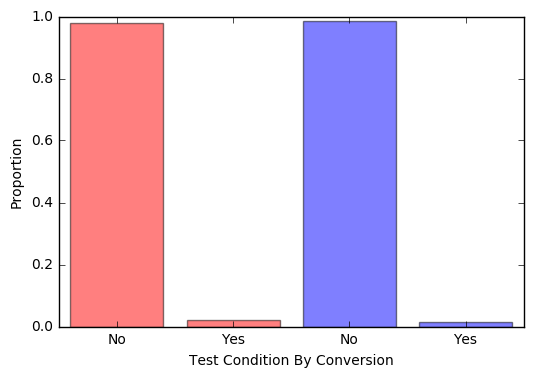

In [10]:
y_pos = np.arange(len(counts['test_condition']))

plt.bar(y_pos, counts['proportions'], align='center', alpha=0.5, color =['red', 'red', 'blue', 'blue'])
plt.xticks(y_pos, counts['conversion'])
plt.ylabel('Proportion')
plt.xlabel('Test Condition By Conversion')

 
plt.show()

**So if I did this right, it seems that most people aren't really converting over regardless of test condition.** Additionally, I don't think you need statistics to really show that this is true.

Following this exploratory logic, let's continue to poke around the data to examine if there are any trends: and from there we might think about using some sort of ML for actionable insights, if necessary.

Again, let's run some SQL queries to grab some data and look at it (instead of using pandas to do all the heavy lifting). 

Note that there are many other variables to group by, and it might be interesting to see if user behavior depends on where they were referred from, or what platform they might be using.

In [11]:
sql_query = """
SELECT source, COUNT(*) AS counts
FROM test_results
GROUP BY source
ORDER BY COUNT(*) DESC;
"""
pd.read_sql_query(sql_query, con)

,source,counts
0,direct_traffic,60357
1,ads-google,59379
2,ads_facebook,53396
3,ads_other,29876
4,seo-google,23175
5,ads-bing,22873
6,seo_facebook,21205
7,friend_referral,20695
8,seo-other,9260
9,ads-yahoo,7583


In [12]:
sql_query = """
SELECT device, COUNT(*)
FROM test_results
GROUP BY device
ORDER BY COUNT(*) DESC;
"""
pd.read_sql_query(sql_query, con)

,device,count
0,mobile,186471
1,web,130329


In [13]:
sql_query = """
SELECT device, source, COUNT(*) AS counts
FROM test_results
GROUP BY device, source
ORDER BY COUNT(*) DESC;
"""
pd.read_sql_query(sql_query, con)

,device,source,counts
0,mobile,direct_traffic,35784
1,mobile,ads-google,34895
2,mobile,ads_facebook,31679
3,web,direct_traffic,24573
4,web,ads-google,24484
5,web,ads_facebook,21717
6,mobile,ads_other,17356
7,mobile,seo-google,13718
8,mobile,ads-bing,13535
9,web,ads_other,12520


In [14]:
sql_query = """
SELECT device, COUNT(*) AS counts,
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition
FROM test_results
WHERE converted = 1
GROUP BY test, converted, device
ORDER BY COUNT(*) DESC;
"""
pd.read_sql_query(sql_query, con)

,device,counts,conversion,test_condition
0,mobile,2395,Yes,Control
1,web,1640,Yes,Control
2,mobile,1065,Yes,Test
3,web,708,Yes,Test


**So this tidbit is interesting.** Mobile users are more likely to convert over. In general. Maybe prioritizing mobile users in general, is a more prudent way to 1) Conduct an A/B focusing more on mobile user behavior, 2) Or simply raise prices in general, since mobile users are more likely to convert anyways?

In [15]:
print 2395 / 4035.0
print 1640 / 4035.0
print 1065 / 1773.0
print 708 / 1773.0

0.59355638166
0.40644361834
0.600676818951
0.399323181049


In [16]:
sql_query = """
SELECT device, COUNT(*) AS counts,
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition
FROM test_results
WHERE converted = 0
GROUP BY test, converted, device
ORDER BY COUNT(*) DESC;
"""
pd.read_sql_query(sql_query, con)

,device,counts,conversion,test_condition
0,mobile,118086,No,Control
1,web,80606,No,Control
2,mobile,64925,No,Test
3,web,47375,No,Test


In [17]:
print 118086 / 198692.0
print 80606 / 198692.0
print 64925 / 112300.0
print 47375 / 112300.0

0.594316832082
0.405683167918
0.578138913624
0.421861086376


In general, there seems to be more mobile users. At minimum, I still think that *at minimum*, testing on mobile users may be more interesting. 

The company owner was also wondering if the dates of the tests mattered, so let's take a look at that. My approach here is to bin each set of data into months.

## Data for March.

In [18]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition,
    
    CASE WHEN test = 0 THEN (count(converted) * 39)
    ELSE (count(converted)*59) END AS Revenue
    
FROM test_results
WHERE time_stamp >= '2015-03-02' AND time_stamp <= '2015-04-01'
GROUP BY test, converted;
"""
pd.read_sql_query(sql_query, con).head(10)

,count,conversion,test_condition,revenue
0,63990,No,Control,2495610
1,1283,Yes,Control,50037
2,36310,No,Test,2142290
3,595,Yes,Test,35105


## Data for April.

In [19]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition
FROM test_results
WHERE time_stamp >= '2015-03-02' AND time_stamp <= '2015-04-01'
GROUP BY test, converted;
"""
pd.read_sql_query(sql_query, con)

,count,conversion,test_condition
0,63990,No,Control
1,1283,Yes,Control
2,36310,No,Test
3,595,Yes,Test


In [20]:
sql_query = """
SELECT id, converted, test
FROM test_results
WHERE time_stamp >= '2015-03-02' AND time_stamp <= '2015-04-01';
"""
mar = pd.read_sql_query(sql_query, con)
mar['month'] = 'Mar'
mar.head()

,id,converted,test,month
0,600150,0,0,Mar
1,798371,1,1,Mar
2,447194,0,1,Mar
3,460593,1,0,Mar
4,552048,0,1,Mar


## Data for May

In [21]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition,
    CASE WHEN test = 0 THEN (count(converted) * 39)
    ELSE (count(converted)*59) END AS Revenue
FROM test_results
WHERE time_stamp >= '2015-04-01' AND time_stamp <= '2015-05-01'
GROUP BY test, converted;
"""
pd.read_sql_query(sql_query, con)

,count,conversion,test_condition,revenue
0,68807,No,Control,2683473
1,1428,Yes,Control,55692
2,38337,No,Test,2261883
3,592,Yes,Test,34928


In [22]:
sql_query = """
SELECT id, converted, test
FROM test_results
WHERE time_stamp >= '2015-04-01' AND time_stamp <= '2015-05-01';
"""
apr = pd.read_sql_query(sql_query, con)
apr['month'] = 'Apr'
apr.head()

,id,converted,test,month
0,317970,0,0,Apr
1,169971,0,0,Apr
2,431639,0,1,Apr
3,590182,0,0,Apr
4,425567,0,0,Apr


In [23]:
sql_query = """
SELECT count(converted),
    CASE WHEN converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition,
    CASE WHEN test = 0 THEN (count(converted) * 39)
    ELSE (count(converted)*59) END AS Revenue
FROM test_results
WHERE time_stamp >= '2015-05-01'
GROUP BY test, converted;
"""
pd.read_sql_query(sql_query, con)

,count,conversion,test_condition,revenue
0,71329,No,Control,2781831
1,1430,Yes,Control,55770
2,40583,No,Test,2394397
3,637,Yes,Test,37583


In [24]:
sql_query = """
SELECT id, converted, test
FROM test_results
WHERE time_stamp >= '2015-05-01';
"""
may = pd.read_sql_query(sql_query, con)
may['month'] = 'May'
may.head()

,id,converted,test,month
0,604839,0,0,May
1,624057,0,0,May
2,685636,0,1,May
3,820854,0,0,May
4,606479,0,0,May


**Simple eyeballing of the numbers might indicate that each month really didn't differ in terms of traffic...*

But how can we be so sure? Maybe we need to validate this with some hypothesis testing.

My approach would be the following: did the proportion of conversion rates or non-conversion rates differ by month? Can we do one of the following confirm that, ANOVA, Chi-Sq test, t-test?

**I created data frames for march, april and may, then combined them together to do 2-Way, Between-Subjects ANOVA.**

In [25]:
frames = [mar, apr, may]

In [26]:
dates = pd.concat(frames)

In [27]:
dates.head()

,id,converted,test,month
0,600150,0,0,Mar
1,798371,1,1,Mar
2,447194,0,1,Mar
3,460593,1,0,Mar
4,552048,0,1,Mar


**I ran the binned data in an ANOVA (in R, because I'm lazy)**, but also using `statsmodels`. The data are mildly imbalanced, but on first glance, the dates don't seem to matter.

Since dates (month) doesn't matter **perhaps a single month is a appropriate for this type of test.** This would save time and money, since we don't necessarily need to run the test for an entire 3-4 months. That's a long time!

In [28]:
cw_lm=ols('converted ~ C(test) + C(month)', data=dates).fit() #Specify C for Categorical

print(sm.stats.anova_lm(cw_lm, typ=2))

               sum_sq        df          F        PR(>F)
C(test)      1.385170       1.0  76.973225  1.741027e-18
C(month)     0.007111       2.0   0.197585  8.207105e-01
Residual  5854.234270  325317.0        NaN           NaN


**I also wanted to explore if there was an overall difference in region**, irrespective of test condition or conversion.

In [29]:
sql_query = """
SELECT u.city, count(u.city) as counts,
    CASE WHEN t.converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN t.test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition

FROM test_results t INNER JOIN user_table u
ON t.id = u.id
WHERE test = 0 AND converted = 1
GROUP BY u.city,t.converted, t.test
ORDER BY counts DESC
LIMIT 50
"""
user_data = pd.read_sql_query(sql_query, con)

In [30]:
sql_query = """
SELECT count(t.converted) AS Count,
    CASE WHEN u.lat >= 37 AND u.long >= -94 THEN 'Midwest/Atlantic/NE'
        WHEN u.lat <= 37 and u.long >= -94 THEN 'South/SE'
        WHEN u.lat <=37 and u.long <= -84 THEN 'West/SW'
        ELSE 'West/NW' END AS Region
FROM test_results t INNER JOIN user_table u
ON t.id = u.id
WHERE test = 1 AND converted = 1
GROUP BY Region
ORDER BY count DESC
"""
pd.read_sql_query(sql_query, con)

,count,region
0,585,Midwest/Atlantic/NE
1,451,West/SW
2,274,South/SE
3,220,West/NW


In [31]:
sql_query = """
SELECT count(t.converted) AS Count,
    CASE WHEN u.lat >= 37 AND u.long >= -94 THEN 'Midwest/Atlantic/NE'
        WHEN u.lat <= 37 and u.long >= -94 THEN 'South/SE'
        WHEN u.lat <=37 and u.long <= -84 THEN 'West/SW'
        ELSE 'West/NW' END AS Region
FROM test_results t INNER JOIN user_table u
ON t.id = u.id
WHERE test = 0 AND converted = 1
GROUP BY Region
ORDER BY count DESC
"""
region = pd.read_sql_query(sql_query, con)
region.head()

,count,region
0,1307,Midwest/Atlantic/NE
1,1040,West/SW
2,607,South/SE
3,535,West/NW


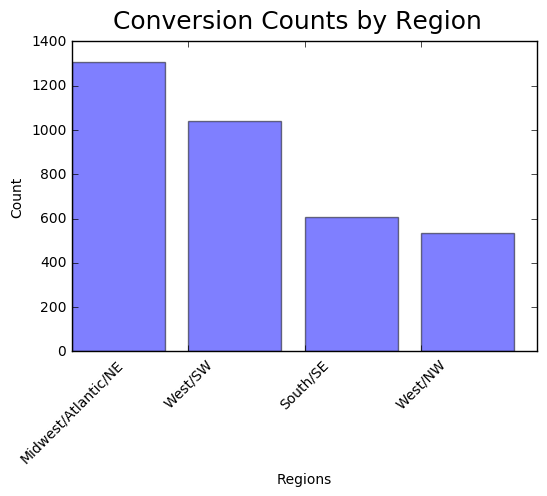

In [32]:
y_pos = np.arange(len(region['region']))
fig = plt.figure(figsize=(6,4), dpi=800)
fig.suptitle('Conversion Counts by Region', fontsize=18)
plt.bar(y_pos, region['count'], alpha=0.5)
plt.xticks(y_pos, region['region'], rotation = 45)
plt.ylabel('Count')
plt.xlabel('Regions')

 
plt.show()


In [33]:
sql_query = """
SELECT u.city, count(u.city) as counts,
    CASE WHEN t.converted = 0 THEN 'No'
    ELSE 'Yes' END AS Conversion,
    CASE WHEN t.test = 0 THEN 'Control'
    ELSE 'Test' END AS Test_Condition

FROM test_results t INNER JOIN user_table u
ON t.id = u.id
WHERE test = 1 AND converted = 1
GROUP BY u.city,t.converted, t.test
ORDER BY counts DESC
LIMIT 50
"""
user_data2 = pd.read_sql_query(sql_query, con)

In [34]:
user_data.head()

,city,counts,conversion,test_condition
0,New York,307,Yes,Control
1,Houston,83,Yes,Control
2,Chicago,66,Yes,Control
3,San Antonio,59,Yes,Control
4,Los Angeles,56,Yes,Control


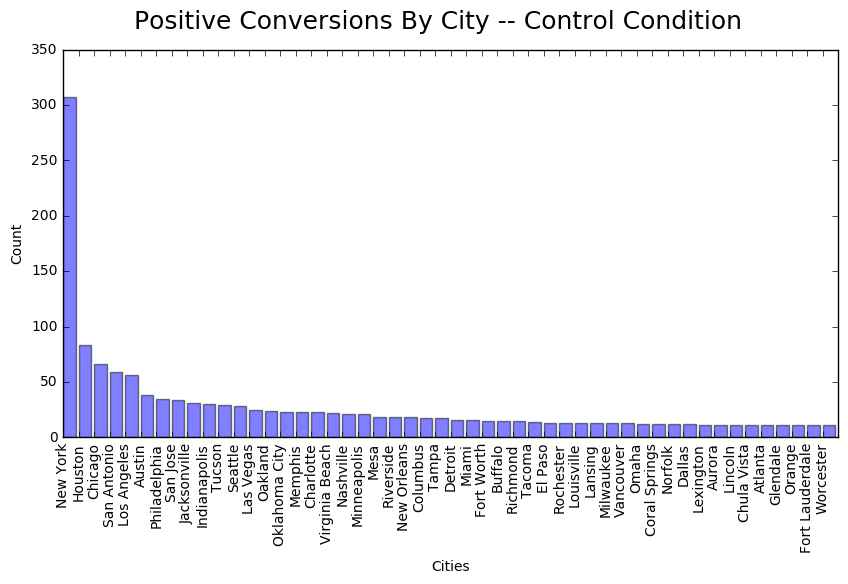

In [35]:
y_pos = np.arange(len(user_data['city']))
fig = plt.figure(figsize=(10,5), dpi=800)
fig.suptitle('Positive Conversions By City -- Control Condition', fontsize=18)
plt.bar(y_pos, user_data['counts'], alpha=0.5)
plt.xticks(y_pos, user_data['city'], rotation = 'vertical')
plt.ylabel('Count')
plt.xlabel('Cities')

 
plt.show()

**Generally speaking, we see conversion rates mirror gross regional variation.**

To get back at the question at hand:

1) There are so few people converted (i.e. buying) the product in general, it might not be prudent to up the price. If there was a greater uptick in conversion (on a large factor), then I might consider changing the product.

2) Holistic view of behavior: As mentioned above, not a whole lot of individuals converted. What I think was interesting is that there are more people on mobile than there are web, so maybe that would be an interesting audience to target. To further support this, mobile users seem to be a bit more likely to convert over to purchasing the product. More finely examining the type of ads and searches (then optimizing them) could be a way to increase conversion rates.

3) My analysis shows that the test seems to be running too long. A month OR shorter would probably prudent.
